In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
#import size data

size_data = pd.read_csv('output_bestparams/size.csv')
val_data = pd.read_csv('a4c-video-dir/FileList.csv')
volume_tracings = pd.read_csv('a4c-video-dir/VolumeTracings.csv')
val_data = val_data[val_data['Split'] == 'TEST']


In [ ]:
'''
key_frames = volume_tracings[['FileName', 'Frame']]
#remove duplicates
key_frames = key_frames.drop_duplicates()
#rename columns
key_frames.columns = ['Filename', 'Frame']
#merge size data with key frames
size_data = pd.merge(size_data, key_frames, how='inner')
val_data = val_data[val_data['Split'] == 'TEST']
'''

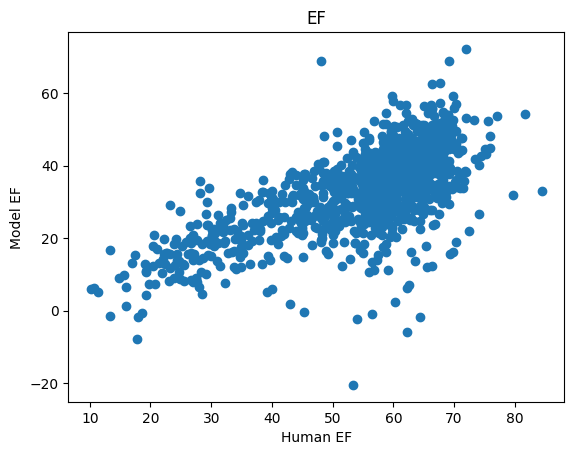

In [ ]:
'''
#create a new column to store the size data

model_ESVs = []
model_EDVs = []
model_EFs = []

#loop through the data and add the size data
unique_filenames = np.unique(size_data['Filename'])
for filename in unique_filenames:
    Model_EDV_size = size_data[(size_data['Filename'] == filename) & (size_data['HumanSmall'] == 1)]['Size'].values[0]
    Model_ESV_size = size_data[(size_data['Filename'] == filename) & (size_data['HumanLarge'] == 1)]['Size'].values[0]
    Model_EF = 100*(Model_EDV_size - Model_ESV_size)/Model_EDV_size
    FileName = filename.split('.')[0]
    val_data.loc[val_data['FileName'] == FileName, 'Model_ESV'] = Model_ESV_size
    val_data.loc[val_data['FileName'] == FileName, 'Model_EDV'] = Model_EDV_size
    val_data.loc[val_data['FileName'] == FileName, 'Model_EF'] = Model_EF

#val_data['Model_ESV'] = model_ESVs
#val_data['Model_EDV'] = model_EDVs
#val_data['Model_EF'] = model_EFs

#plot the data
plt.figure()
plt.scatter(val_data['EF'], val_data['Model_EF'])
plt.xlabel('Human EF')
plt.ylabel('Model EF')
plt.title('EF')
plt.show()
'''

In [3]:

def getEF(area, area_buffer):
    area_buffer.append(area)  # Automatically removes the oldest element if full
    currMax =  max(area_buffer)
    currMin =  min(area_buffer)
    
     # Prevent division by zero
    currEF = (currMax**(3/2) - currMin**(3/2)) / currMax**(3/2) if currMax != 0 else 0  
    return (currEF, area_buffer)  # Return EF and updated buffer



In [5]:
from collections import deque
unique_filenames = np.unique(size_data['Filename'])
for filename in unique_filenames:
    # Read and process each frame
    frame_number = 0
    areas = [0, 0] # currMaxArea, currMinArea
    maxEF = 0
    prevEF = 0
    currEF = 0.00001
    i = 0
    period = 40
    area_buffer = deque(maxlen=period)  # Fixed-size buffer"
    video_data = size_data[size_data['Filename'] == filename]
    EF_list = []
    for index, row in video_data.iterrows():
        area = row['Size']
        currEF, area_buffer = getEF(area, area_buffer)
        EF_list.append(currEF)
    # Remove the first 40 frames
    EF_list = EF_list[period:]
    
    # Check if EF_list is not empty before calculating statistics
    if len(EF_list) > 0:
        avg_EF = np.mean(EF_list)
        max_EF = np.max(EF_list)
        FileName = filename.split('.')[0]
        val_data.loc[val_data['FileName'] == FileName, 'Model_EF'] = avg_EF * 100
    else:
        print(f"Warning: EF_list is empty for file {filename}. Skipping calculations.")



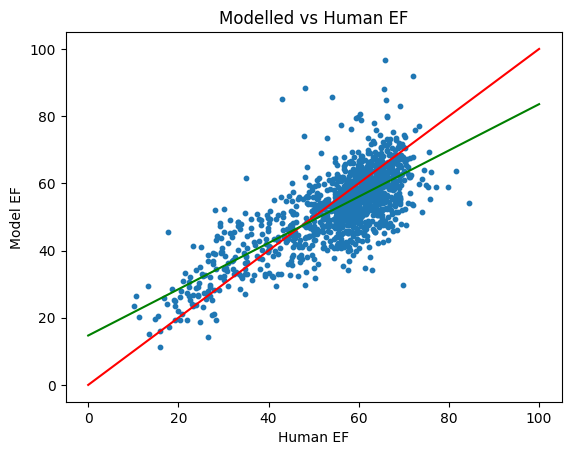

In [10]:

#plot the data
plt.figure()
plt.scatter(val_data['EF'], val_data['Model_EF'], s=10)
#add line x = y
plt.plot([0, 100], [0, 100], color='red')
#add line of best fit
# Remove rows with NaN values in EF or Model_EF
filtered_data = val_data.dropna(subset=['EF', 'Model_EF'])

# Perform linear regression
m, b = np.polyfit(filtered_data['EF'], filtered_data['Model_EF'], 1)
plt.plot([0, 100], m * np.array([0, 100]) + b, color='green')
plt.xlabel('Human EF')
plt.ylabel('Model EF')
plt.title('Modelled vs Human EF')
plt.show()


Accuracy:  0.8136256851996868


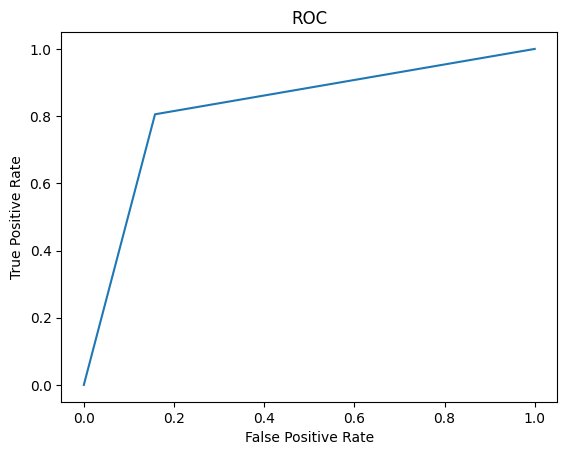

AUC:  0.8237744057724957


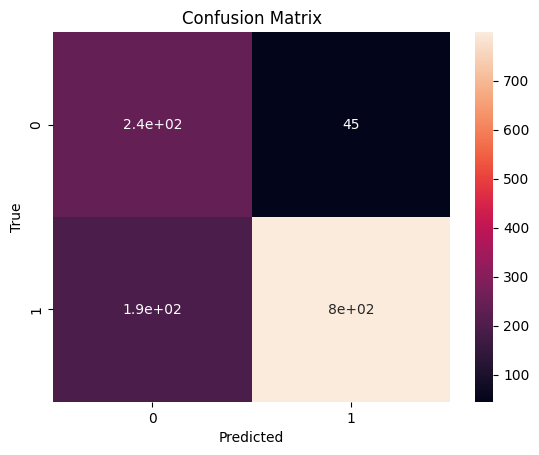

In [11]:
#Classify the EF as 1 if >50 and 0 if <50 for both human and model
val_data['Human_EF_class'] = 0
val_data['Model_EF_class'] = 0
val_data.loc[val_data['EF'] > 50, 'Human_EF_class'] = 1
val_data.loc[val_data['Model_EF'] > 50, 'Model_EF_class'] = 1

#calculate the accuracy
accuracy = np.mean(val_data['Human_EF_class'] == val_data['Model_EF_class'])
print('Accuracy: ', accuracy)

#calculate and plot the AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_data['Human_EF_class'], val_data['Model_EF_class'])
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

#calculate the AUC
AUC = roc_auc_score(val_data['Human_EF_class'], val_data['Model_EF_class'])
print('AUC: ', AUC)

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(val_data['Human_EF_class'], val_data['Model_EF_class'])
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



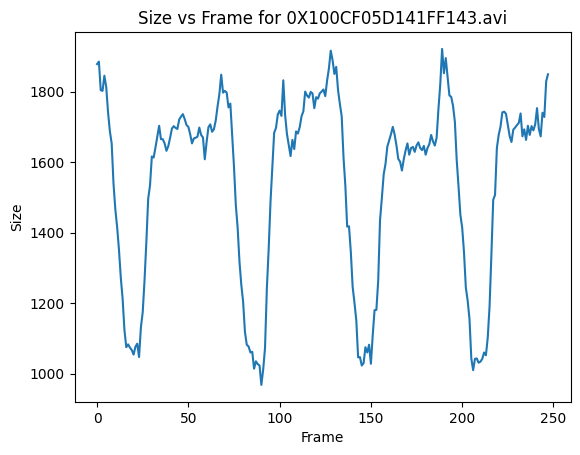

In [ ]:
unique_filenames = np.unique(size_data['Filename'])

#plot size data
size_data1 = size_data[size_data['Filename'] == unique_filenames[0]]

#plot size data1
plt.figure()
plt.plot(size_data1['Frame'], size_data1['Size'])
plt.xlabel('Frame')
plt.ylabel('Size')
plt.title('Size vs Frame for ' + unique_filenames[0])
plt.show()


In [ ]:
#save a plot for each file
output_path = 'output_swinUnet1/size_plots/'
#create a directory for the plots
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)
for filename in unique_filenames:
    size_data1 = size_data[size_data['Filename'] == filename]
    plt.figure()
    plt.plot(size_data1['Frame'], size_data1['Size'])
    plt.xlabel('Frame')
    plt.ylabel('Size')
    plt.title('Size vs Frame for ' + filename)
    plt.savefig(output_path + filename + '.png')